Setup enviroment

In [2]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.0+cu121


In [3]:
!pip install -q dgl

In [4]:
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric import nn
import torch_geometric.transforms as T

In [5]:
import json
import pandas as pd
import numpy as np
import random
import dgl
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn

/tmp/ipykernel_3782458/4213285088.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
from sklearn.metrics import f1_score
import numpy as np

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load node2id dictionary

In [9]:
os.path.isdir("/gpfs/gibbs/pi/gerstein/yc774/project/miRGD/graph")

True

In [10]:
#open files
proj_dir = os.path.join("/gpfs/gibbs/pi/gerstein/yc774/project/miRGD/graph")
f = open(os.path.join(proj_dir,"node2id.json"))
node2id = json.load(f)

f = open(os.path.join(proj_dir,"id2node.json"))
id2node = json.load(f)

In [11]:
relation = ["mm","dd","gg","md","mg","dg"]

edge_index = {}
for rel in relation:
  pth = os.path.join(proj_dir,"{}_edge.csv".format(rel))
  edge_df = pd.read_csv(pth)
  edge_list = np.transpose(edge_df.values)
  edge_index[rel] = torch.tensor(edge_list).long()

In [12]:
edge_index

{'mm': tensor([[ 898,  898,  898,  ...,  694,  482,  482],
         [ 841, 1069,  541,  ...,  953, 1011,  147]]),
 'dd': tensor([[1175, 1175, 1175,  ..., 1134, 1134, 1134],
         [1180, 1144, 1208,  ..., 1168, 1141, 1139]]),
 'gg': tensor([[2147, 2147, 2147,  ..., 6556, 8910, 5385],
         [8388, 7092, 9807,  ..., 1735, 1735, 1735]]),
 'md': tensor([[ 898,  898,  898,  ...,  270,  946,  250],
         [1193, 1180, 1214,  ..., 1191, 1213, 1213]]),
 'mg': tensor([[  32,  832,  832,  ...,  589,  589,  100],
         [5215, 7835, 7835,  ..., 5135, 9328, 4016]]),
 'dg': tensor([[5925, 5925, 4194,  ..., 7342, 5467, 5467],
         [1183, 1153, 1153,  ..., 1204, 1131, 1148]])}

In [13]:
miRNA_id = list(range(1109))
disease_id = list(range(1109,1222))
gene_id = list(range(1222,10532))


# convert old unique id to seperete set of new ID
disease_new_id_dict = {}
new_id = 0
for old_id in disease_id:
  disease_new_id_dict[old_id] = new_id
  new_id+=1

gene_new_id_dict = {}
new_id = 0
for old_id in gene_id:
  gene_new_id_dict[old_id] = new_id
  new_id+=1



new_edge_index = {}
new_edge_index['mm'] = edge_index['mm']

new_edge_index['dd'] = torch.tensor([
  [disease_new_id_dict[old_id] for old_id in edge_index['dd'][0].numpy()],
  [disease_new_id_dict[old_id] for old_id in edge_index['dd'][1].numpy()],
])
new_edge_index['gg'] = torch.tensor([
  [gene_new_id_dict[old_id] for old_id in edge_index['gg'][0].numpy()],
  [gene_new_id_dict[old_id] for old_id in edge_index['gg'][1].numpy()],
])
new_edge_index['md'] = torch.tensor([
  edge_index['md'][0].numpy(),
  [disease_new_id_dict[old_id] for old_id in edge_index['md'][1].numpy()],
])

new_edge_index['mg'] = torch.tensor([
  edge_index['mg'][0].numpy(),
  [gene_new_id_dict[old_id] for old_id in edge_index['mg'][1].numpy()]
])

new_edge_index['gd'] = torch.tensor([
  [gene_new_id_dict[old_id] for old_id in edge_index['dg'][0].numpy()],
  [disease_new_id_dict[old_id] for old_id in edge_index['dg'][1].numpy()],
])


/tmp/ipykernel_3782458/2437488178.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  new_edge_index['md'] = torch.tensor([


In [14]:
new_edge_index

{'mm': tensor([[ 898,  898,  898,  ...,  694,  482,  482],
         [ 841, 1069,  541,  ...,  953, 1011,  147]]),
 'dd': tensor([[66, 66, 66,  ..., 25, 25, 25],
         [71, 35, 99,  ..., 59, 32, 30]]),
 'gg': tensor([[ 925,  925,  925,  ..., 5334, 7688, 4163],
         [7166, 5870, 8585,  ...,  513,  513,  513]]),
 'md': tensor([[898, 898, 898,  ..., 270, 946, 250],
         [ 84,  71, 105,  ...,  82, 104, 104]]),
 'mg': tensor([[  32,  832,  832,  ...,  589,  589,  100],
         [3993, 6613, 6613,  ..., 3913, 8106, 2794]]),
 'gd': tensor([[4703, 4703, 2972,  ..., 6120, 4245, 4245],
         [  74,   44,   44,  ...,   95,   22,   39]])}

In [15]:

n_hetero_features = 10

hetero_graph = dgl.heterograph({
    ('miRNA', 'similar_to', 'miRNA'): (new_edge_index['mm'][0], new_edge_index['mm'][1]),
    ('gene', 'similar_to', 'gene'): (new_edge_index['gg'][0], new_edge_index['gg'][1]),
    ('disease', 'similar_to', 'disease'): (new_edge_index['dd'][0], new_edge_index['dd'][1]),
    ('miRNA', 'target_to', 'gene'): (new_edge_index['mg'][0], new_edge_index['mg'][1]),
    ('miRNA', 'associate_with', 'disease'): (new_edge_index['md'][0], new_edge_index['md'][1]),
    ('gene', 'related_to', 'disease'): (new_edge_index['gd'][0], new_edge_index['gd'][1])})

n_miRNA = hetero_graph.num_nodes('miRNA')
n_gene = hetero_graph.num_nodes('gene')
n_disease= hetero_graph.num_nodes('disease')

hetero_graph.nodes['miRNA'].data['feature'] = torch.randn(n_miRNA, n_hetero_features)
hetero_graph.nodes['gene'].data['feature'] = torch.randn(n_gene, n_hetero_features)
hetero_graph.nodes['disease'].data['feature'] = torch.randn(n_disease, n_hetero_features)

hetero_graph

Graph(num_nodes={'disease': 113, 'gene': 9308, 'miRNA': 1109},
      num_edges={('disease', 'similar_to', 'disease'): 4863, ('gene', 'related_to', 'disease'): 9596, ('gene', 'similar_to', 'gene'): 519568, ('miRNA', 'associate_with', 'disease'): 3999, ('miRNA', 'similar_to', 'miRNA'): 346623, ('miRNA', 'target_to', 'gene'): 25405},
      metagraph=[('disease', 'disease', 'similar_to'), ('gene', 'disease', 'related_to'), ('gene', 'gene', 'similar_to'), ('miRNA', 'disease', 'associate_with'), ('miRNA', 'miRNA', 'similar_to'), ('miRNA', 'gene', 'target_to')])

In [16]:
hetero_graph.nodes['miRNA']

NodeSpace(data={'feature': tensor([[ 0.8467,  0.8671, -1.3827,  ..., -0.6743, -0.2112, -1.7691],
        [ 1.6073, -0.1268,  0.1059,  ..., -0.6812,  2.1987,  0.1235],
        [ 1.5278, -0.9245, -1.2845,  ..., -0.5479, -0.0222,  0.6367],
        ...,
        [-0.6066, -0.4652, -0.0036,  ..., -0.2403, -1.7012, -0.9087],
        [ 0.6391, -1.1978,  1.2091,  ...,  0.0398, -0.5067, -0.7620],
        [-1.6135, -1.4273,  0.7165,  ...,  1.9327, -1.3252,  0.3662]])})

Link Prediction - Random Feature

In [17]:
class RGCN_3layer(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super().__init__()

        self.conv1 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(in_feats, hid_feats)
            for rel in rel_names}, aggregate='mean')
        self.conv2 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(hid_feats, hid_feats)
            for rel in rel_names}, aggregate='mean')
        self.conv3 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(hid_feats, out_feats)
            for rel in rel_names}, aggregate='mean')

    def forward(self, graph, inputs, mask):
        # inputs are features of nodes
        h = self.conv1(graph, inputs, mod_kwargs={
            'associate_with': {'edge_weight': mask}})
        h = {k: F.relu(v) for k, v in h.items()}

        h = self.conv2(graph, h, mod_kwargs={
            'associate_with': {'edge_weight': mask}})
        h = {k: F.relu(v) for k, v in h.items()}

        h = self.conv3(graph, h, mod_kwargs={
            'associate_with': {'edge_weight': mask}})

        return h

def construct_negative_graph(graph, k, etype):
    utype, _, vtype = etype
    src, dst = graph.edges(etype=etype)
    neg_src = src.repeat_interleave(k)
    neg_dst = torch.randint(0, graph.num_nodes(vtype), (len(src) * k,))
    return dgl.heterograph(
        {etype: (neg_src, neg_dst)},
        num_nodes_dict={ntype: graph.num_nodes(ntype) for ntype in graph.ntypes})

class HeteroDotProductPredictor(nn.Module):
    def forward(self, graph, h, etype):
        # h contains the node representations for each node type computed from
        # the GNN defined in the previous section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'), etype=etype)
            return graph.edges[etype].data['score']

class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, rel_names):
        super().__init__()
        self.sage = RGCN_3layer(in_features, hidden_features, out_features, rel_names)
        self.pred = HeteroDotProductPredictor()
    def forward(self, g, neg_g, x, etype, pos_train_mask):
        h = self.sage(g, x, pos_train_mask)
        return self.pred(g, h, etype), self.pred(neg_g, h, etype)


n_hetero_features = 32
n_hidden = 64
n_output = 32
hetero_graph = dgl.heterograph({
    ('miRNA', 'similar_to', 'miRNA'): (new_edge_index['mm'][0], new_edge_index['mm'][1]),
    ('gene', 'similar_to', 'gene'): (new_edge_index['gg'][0], new_edge_index['gg'][1]),
    ('disease', 'similar_to', 'disease'): (new_edge_index['dd'][0], new_edge_index['dd'][1]),
    ('miRNA', 'target_to', 'gene'): (new_edge_index['mg'][0], new_edge_index['mg'][1]),
    ('miRNA', 'associate_with', 'disease'): (new_edge_index['md'][0], new_edge_index['md'][1]),
    ('gene', 'related_to', 'disease'): (new_edge_index['gd'][0], new_edge_index['gd'][1])})

n_miRNA = hetero_graph.num_nodes('miRNA')
n_gene = hetero_graph.num_nodes('gene')
n_disease= hetero_graph.num_nodes('disease')

hetero_graph.nodes['miRNA'].data['feature'] = torch.randn(n_miRNA, n_hetero_features)
hetero_graph.nodes['gene'].data['feature'] = torch.randn(n_gene, n_hetero_features)
hetero_graph.nodes['disease'].data['feature'] = torch.randn(n_disease, n_hetero_features)

def compute_loss_with_mask(pos_score, neg_score):
    # Margin loss
    n_edges = pos_score.shape[0]
    return (1 - pos_score +  neg_score.view(n_edges, -1)).clamp(min=0).mean()


k = 5
model = Model(n_hetero_features, n_hidden, n_output, hetero_graph.etypes)
miRNA_feats = hetero_graph.nodes['miRNA'].data['feature']
gene_feats = hetero_graph.nodes['gene'].data['feature']
disease_feats = hetero_graph.nodes['disease'].data['feature']
node_features = {'miRNA': miRNA_feats, 'gene': gene_feats, 'disease':disease_feats}

num_target_edge = hetero_graph['associate_with'].num_edges()
pos_train_mask = (torch.rand(num_target_edge, 1) > 0.3).float()

pos_train_index = torch.tensor(np.where(pos_train_mask == 1)[0])
pos_valid_index = torch.tensor(np.where(pos_train_mask == 0)[0])

train_loss_accu = []
valid_loss_accu = []

train_accuracy_accu = []
valid_accuracy__accu = []

num_epoch = 200

loss_fn = nn.BCEWithLogitsLoss()

opt = torch.optim.Adam(model.parameters())
for epoch in range(num_epoch):
    negative_graph_train = construct_negative_graph(hetero_graph, k, ('miRNA', 'associate_with', 'disease'))
    pos_score, neg_score = model(hetero_graph, negative_graph_train, node_features, ('miRNA', 'associate_with', 'disease'),pos_train_mask)
    
    perm = torch.randperm(neg_score.size(0))
    neg_train_index = perm[:int(5*sum(pos_train_mask))]
    neg_valid_index = perm[int(5*sum(pos_train_mask)):]

    loss = compute_loss_with_mask(torch.index_select(pos_score, 0, pos_train_index),torch.index_select(neg_score, 0, neg_train_index))

    predict = torch.cat((torch.index_select(pos_score, 0, pos_train_index),torch.index_select(neg_score, 0, neg_train_index)),0)
    target = torch.tensor([1]*torch.index_select(pos_score, 0, pos_train_index).shape[0] + [0]*torch.index_select(neg_score, 0, neg_train_index).shape[0]).unsqueeze(1)
    #target = target.to(device)

    loss = loss_fn(predict, target.float())

    opt.zero_grad()
    loss.backward()
    opt.step()


    predict = torch.cat((torch.index_select(pos_score, 0, pos_valid_index),torch.index_select(neg_score, 0, neg_valid_index)),0)
    target = torch.tensor([1]*torch.index_select(pos_score, 0, pos_valid_index).shape[0] + [0]*torch.index_select(neg_score, 0, neg_valid_index).shape[0]).unsqueeze(1)
    #target = target.to(device)
    valid_loss = loss_fn(predict, target.float())

    train_loss_accu.append(loss.item())
    valid_loss_accu.append(valid_loss.item())

    accu_pos = (torch.index_select(pos_score, 0, pos_valid_index) > 0)
    accu_neg = (torch.index_select(neg_score, 0, neg_valid_index) < 0)
    valid_accu = (sum(accu_pos)+sum(accu_neg))/(len(accu_pos)+len(accu_neg))

    accu_pos = (torch.index_select(pos_score, 0, pos_train_index) > 0)
    accu_neg = (torch.index_select(neg_score, 0, neg_train_index) < 0)
    train_accu = (sum(accu_pos)+sum(accu_neg))/(len(accu_pos)+len(accu_neg))

    train_accuracy_accu.append(train_accu)
    valid_accuracy__accu.append(valid_accu)

    print("epoch: ", epoch, " train loss: ", loss.item(), " valid loss: ",valid_loss.item(), " train_accuracy: ",train_accu," valid accuracy: ",valid_accu)



epoch:  0  train loss:  0.6941037178039551  valid loss:  0.694214940071106  train_accuracy:  tensor([0.1519])  valid accuracy:  tensor([0.1533])
epoch:  1  train loss:  0.6932930946350098  valid loss:  0.6932980418205261  train_accuracy:  tensor([0.3740])  valid accuracy:  tensor([0.3758])
epoch:  2  train loss:  0.6927545666694641  valid loss:  0.6927348971366882  train_accuracy:  tensor([0.8180])  valid accuracy:  tensor([0.8140])
epoch:  3  train loss:  0.6922617554664612  valid loss:  0.6922527551651001  train_accuracy:  tensor([0.8185])  valid accuracy:  tensor([0.8186])
epoch:  4  train loss:  0.691698431968689  valid loss:  0.6917082667350769  train_accuracy:  tensor([0.8183])  valid accuracy:  tensor([0.8169])
epoch:  5  train loss:  0.6909732222557068  valid loss:  0.6909266114234924  train_accuracy:  tensor([0.8216])  valid accuracy:  tensor([0.8211])
epoch:  6  train loss:  0.6899913549423218  valid loss:  0.6900372505187988  train_accuracy:  tensor([0.8299])  valid accuracy

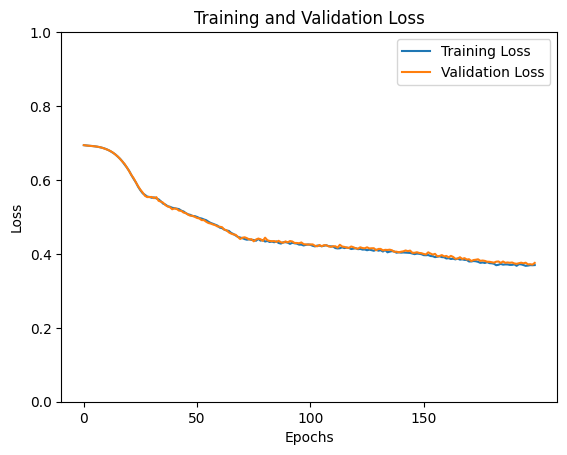

In [19]:
# Generate a sequence of integers to represent the epoch numbers
epochs = range(num_epoch)

# Plot and label the training and validation loss values
plt.plot(epochs, train_loss_accu, label='Training Loss')
plt.plot(epochs, valid_loss_accu, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(range(0, num_epoch, 50))
plt.ylim(ymax = 1, ymin = 0)
# Display the plot
plt.legend(loc='best')
plt.show()

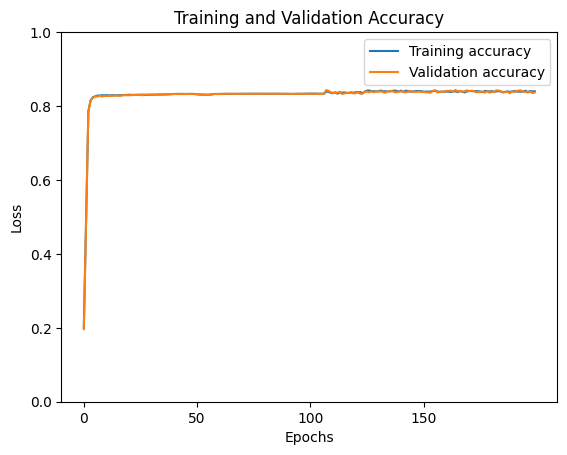

In [25]:
# Generate a sequence of integers to represent the epoch numbers
epochs = range(num_epoch)

# Plot and label the training and validation loss values
plt.plot(epochs, train_accuracy_accu, label='Training accuracy')
plt.plot(epochs, valid_accuracy__accu, label='Validation accuracy')

# Add in a title and axes labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(range(0, num_epoch, 50))
plt.ylim(ymax = 1, ymin = 0)
# Display the plot
plt.legend(loc='best')
plt.show()